In [1]:
import numpy as np
import pandas as pd
import time, warnings
import datetime as dt
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns
warnings.filterwarnings("ignore")
import io

In [2]:
data = pd.read_csv("Online_Retail.csv")
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
data['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain'], dtype=object)

In [4]:
data = data[data['Quantity']>0]
data.dropna(subset=['CustomerID'],how='all',inplace=True)

### RFM Table Preparation

**Recency**

In [5]:
data['date'] = pd.DatetimeIndex(data['InvoiceDate']).date
now = data['date'].max()

# Grouping data by 'CustomerID' and finding most recent purchase date for each customer
recency = data.groupby(by='CustomerID', as_index=False)['date'].max()
recency.columns = ['CustomerID','LastPurshaceDate']

#'Recency'='now'-'LastPurchaseDate'
recency['Recency'] = recency['LastPurshaceDate'].apply(lambda x: (now - x).days)
recency

,CustomerID,LastPurshaceDate,Recency
0,12347.0,2010-12-07,33
1,12348.0,2010-12-16,24
2,12370.0,2010-12-17,23
3,12377.0,2010-12-20,20
4,12383.0,2010-12-22,18
...,...,...,...
968,18245.0,2010-12-19,21
969,18259.0,2010-12-08,32
970,18260.0,2011-01-09,0
971,18269.0,2010-12-08,32


In [6]:
recency.drop('LastPurshaceDate',axis=1,inplace=True)

**Frequency**

In [7]:
data_copy = data
data_copy.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)

#counting number of unique 'InvoiceNo' for each customer
frequency = data_copy.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency.columns = ['CustomerID','Frequency']
frequency.head()

,CustomerID,Frequency
0,12347.0,1
1,12348.0,1
2,12370.0,2
3,12377.0,1
4,12383.0,1


**Monetary**

In [8]:
data['TotalCost'] = data['Quantity'] * data['UnitPrice']

#summing the 'TotalCost' for each customer
monetary = data.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary.columns = ['CustomerID','Monetary']
monetary.head()

,CustomerID,Monetary
0,12347.0,25.2
1,12348.0,39.6
2,12370.0,231.2
3,12377.0,37.2
4,12383.0,30.0


**RFM Table**

In [9]:
temp = recency.merge(frequency,on='CustomerID')
rfm= temp.merge(monetary,on='CustomerID')

rfm.set_index('CustomerID',inplace=True)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,33,1,25.2
12348.0,24,1,39.6
12370.0,23,2,231.2
12377.0,20,1,37.2
12383.0,18,1,30.0


### EDA / Cleaning / Dealing With Outliers

In [10]:
# Counting duplicate rows
duplicate_count = rfm.duplicated().sum()
print("Number of duplicate rows:", duplicate_count)

Number of duplicate rows: 89


In [11]:
rfm.drop_duplicates(inplace=True)

duplicate_count_new = rfm.duplicated().sum()
print("Number of duplicate rows:", duplicate_count_new)

Number of duplicate rows: 0


In [12]:
print(rfm.isnull().sum())

Recency      0
Frequency    0
Monetary     0
dtype: int64


In [13]:
rfm.describe()

,Recency,Frequency,Monetary
count,884.000000,884.000000,884.000000
mean,23.171946,1.728507,99.459819
std,12.212254,2.061029,314.010067
min,0.000000,1.000000,0.420000
25%,19.000000,1.000000,12.987500
50%,26.000000,1.000000,25.200000
75%,32.000000,2.000000,70.425000
max,39.000000,37.000000,4321.390000


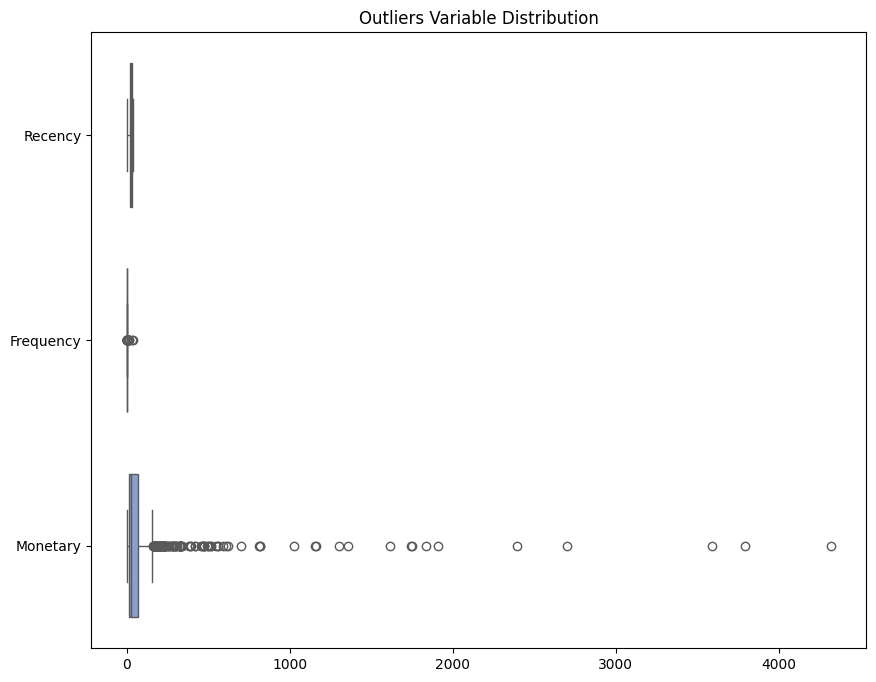

In [14]:
#Boxplot to see outliers
attributes = ['Recency', 'Frequency', 'Monetary']

plt.figure(figsize=(10, 8))

sns.boxplot(data = rfm[attributes], orient="h", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 12)
plt.show()

In [15]:
#Removing outliers
attributes = ['Monetary', 'Recency', 'Frequency']

for attribute in attributes:
    # Calculate quartiles and IQR
    Q1 = rfm[attribute].quantile(0.05)
    Q3 = rfm[attribute].quantile(0.95)
    IQR = Q3 - Q1

    # Remove outliers
    rfm = rfm[(rfm[attribute] >= Q1 - 1.5*IQR) & (rfm[attribute] <= Q3 + 1.5*IQR)]

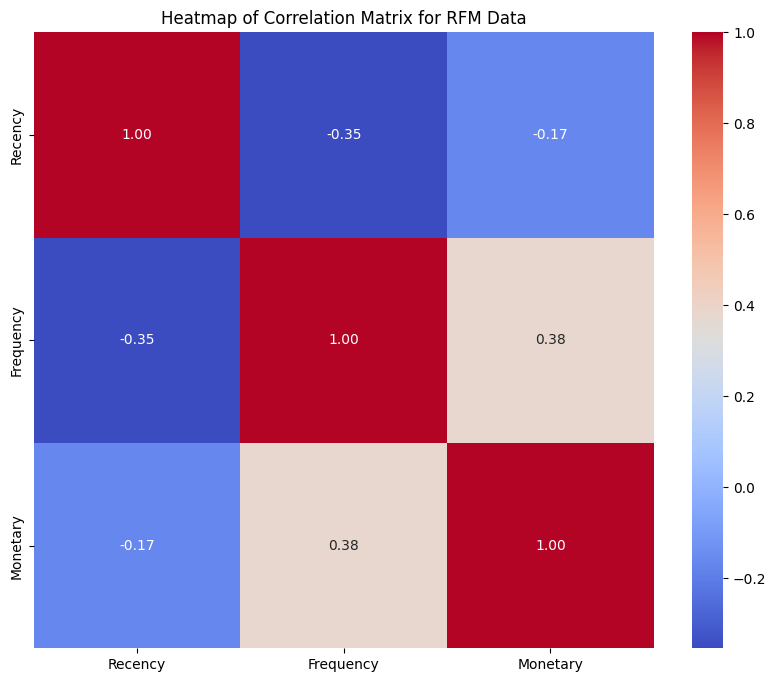

In [16]:
# heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(rfm.corr(), annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Heatmap of Correlation Matrix for RFM Data')
plt.show()

# PCA / K-mean Clustering

Applying PCA with 2 dimensions

In [17]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

rfm_cluster = pd.DataFrame(data=rfm)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(rfm_cluster)

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

Determine optimal number of K using Elbow Method


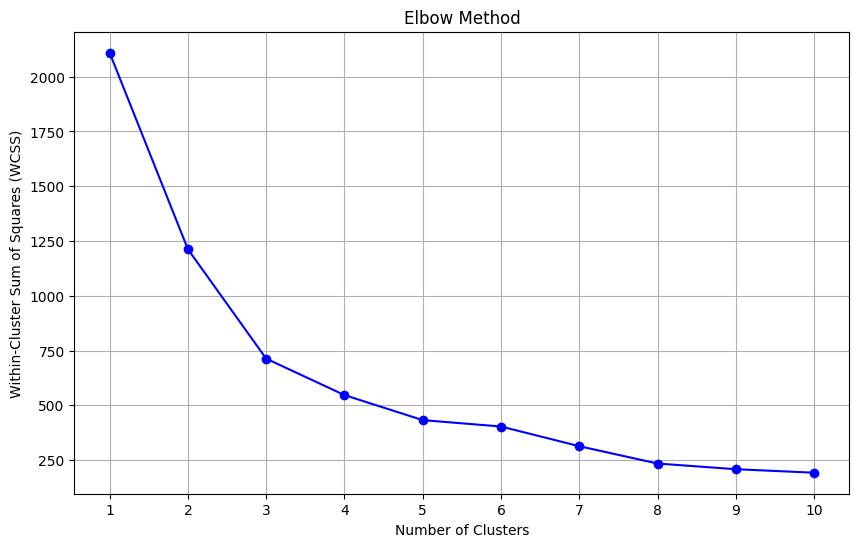

In [18]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(pca_df)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

The optimal K=5

PCA KMean Clustering

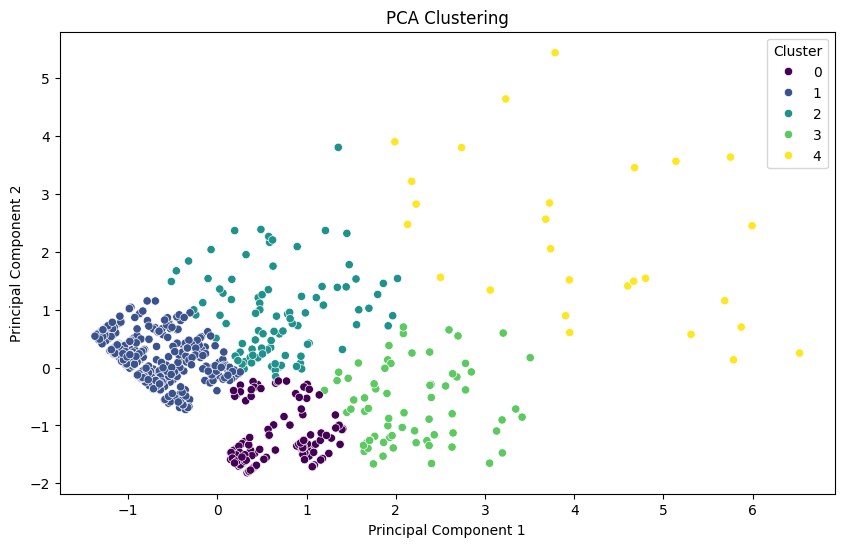

In [19]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=5)
kmeans.fit(pca_df)

pca_df['Cluster'] = kmeans.labels_

#Plot PCA Clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='viridis')
plt.title('PCA Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [20]:
# Calculate mean values for each cluster
rfm_cluster['Cluster'] = kmeans.labels_
cluster_means = rfm_cluster.groupby('Cluster').mean()

print("Mean values for each cluster:")
print(cluster_means)

Mean values for each cluster:
           Recency  Frequency    Monetary
Cluster                                  
0         5.457746   1.514085   33.364507
1        30.005629   1.146341   24.674878
2        27.606383   2.053191  165.364043
3         6.602941   3.338235  114.082500
4        13.592593   3.777778  491.401481


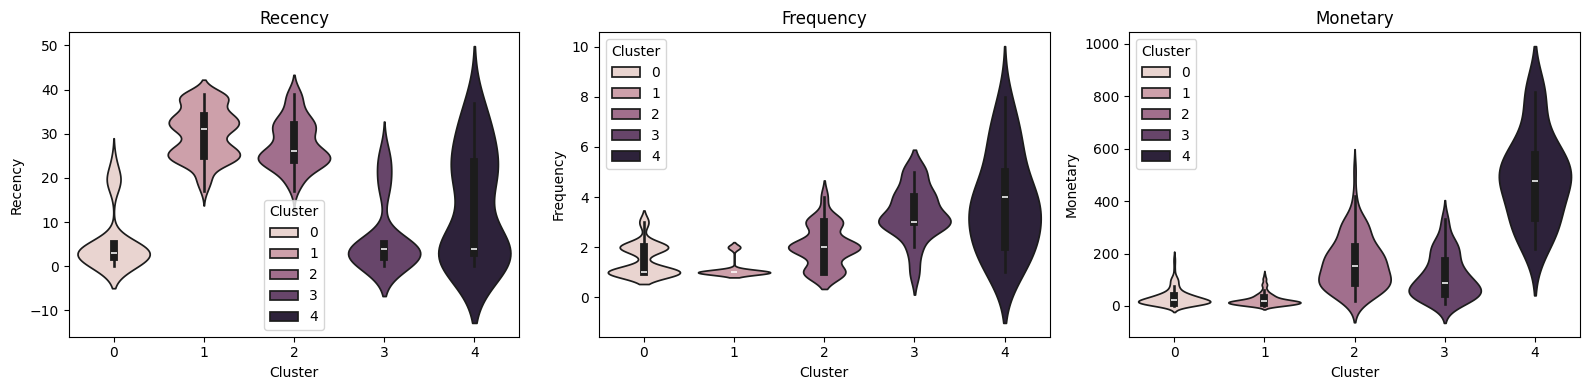

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Create catplot 'Recency'
sns.violinplot(data=rfm_cluster, x="Cluster", y="Recency", hue="Cluster", ax=axes[0])
axes[0].set_title('Recency')

# Create catplot 'Frequency'
sns.violinplot(data=rfm_cluster, x="Cluster", y="Frequency", hue="Cluster", ax=axes[1])
axes[1].set_title('Frequency')

# Create catplot 'Monetary'
sns.violinplot(data=rfm_cluster, x="Cluster", y="Monetary", hue="Cluster", ax=axes[2])
axes[2].set_title('Monetary')

plt.tight_layout()
plt.show()

In [22]:
rfm['Cluster'] = kmeans.labels_

In [23]:
segment_names = {
    0: 'Inactive Shoppers',
    1: 'Occasional Shoppers',
    2: 'Frequent Spenders',
    3: 'High-Value Loyal Shoppers',
    4: 'Regular Shoppers' }

# Map the cluster values to segment names
rfm['Segment'] = rfm['Cluster'].map(segment_names)
print(rfm)

            Recency  Frequency  Monetary  Cluster              Segment
CustomerID                                                            
12347.0          33          1     25.20        1  Occasional Shoppers
12348.0          24          1     39.60        1  Occasional Shoppers
12370.0          23          2    231.20        2    Frequent Spenders
12377.0          20          1     37.20        1  Occasional Shoppers
12383.0          18          1     30.00        1  Occasional Shoppers
...             ...        ...       ...      ...                  ...
18245.0          21          1     17.70        1  Occasional Shoppers
18259.0          32          1     12.60        1  Occasional Shoppers
18260.0           0          2     75.00        0    Inactive Shoppers
18269.0          32          1     18.60        1  Occasional Shoppers
18283.0           3          1      0.85        0    Inactive Shoppers

[864 rows x 5 columns]


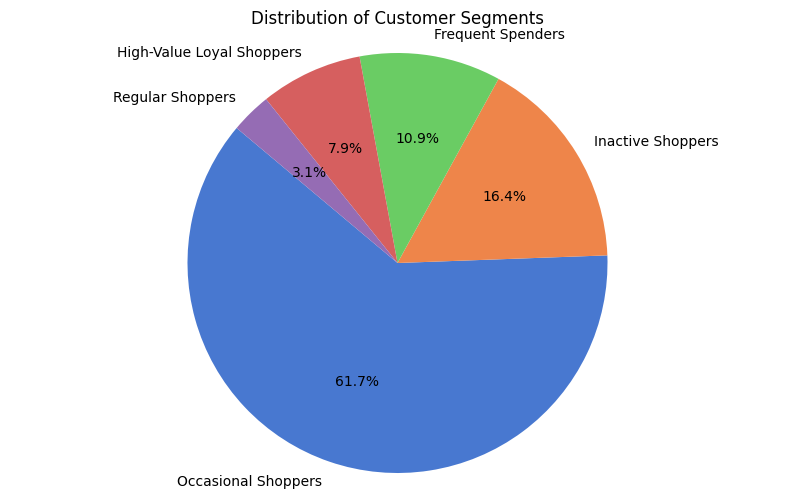

In [24]:
import matplotlib.pyplot as plt

segment_counts = rfm['Segment'].value_counts()

# legend
legend_labels = [f'{segment} ({count})' for segment, count in segment_counts.items()]

plt.figure(figsize=(10, 6))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('muted', len(segment_counts)))
plt.title('Distribution of Customer Segments')
plt.axis('equal')

plt.show()

In [25]:
#rfm = rfm.drop('Cluster', axis=1)
rfm.to_csv("customer_segments.csv")